# Whole brain data processing

In [42]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from cellProcessing_single_WS import *
import zarr
import scipy.ndimage.filters as sfilter
from utils import intesity_mask
from fish_proc.utils.snr import local_correlations_fft

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set up environments

* Install `fish_proc` from github https://github.com/zqwei/fish_processing

In [2]:
## STEP 1: specify data and save path
dir_root = '/nrs/ahrens/jing/giving_up/20190426/fish03/7dpf_HuC-H2B_GCaMP7ff_GU-slow-fwd_fish03_exp02_20190426_221213/im'
save_root = '/nrs/ahrens/jing/giving_up/20190426/fish03/7dpf_HuC-H2B_GCaMP7ff_GU-slow-fwd_fish03_exp02_20190426_221213/weiz_processed/'
dask_tmp = '/nrs/ahrens/jing/giving_up/20190426/fish03/7dpf_HuC-H2B_GCaMP7ff_GU-slow-fwd_fish03_exp02_20190426_221213/weiz_processed/dask-worker-space'
memory_limit = 0 # unlimited

if not os.path.exists(save_root):
    os.makedirs(save_root)

## Preproecssing
This will generate the follow files at `save_root` folder
* `motion_fix_.h5` -- reference image
* `trans_affs.npy` -- affine transform
* `Y_2dnorm_ave.h5` -- average image after detrend
* `local_pca_data.zarr` -- local pca denoised image (This might be used a x4 file size comparing to the raw data), which can be removed afterwards

### Notes
* ZW -- (Rechunk from image to time) I used 500 cores, and it broke down several times, but it is still working (41 minutes on rechunks), try at least 700 cores as a start
* ZW -- (later steps) I used number of blocks + 1 as number of cores (this can be precomputed)
* ZW -- computation time of baseline linearly increases with x, y, and baseline_window in each block (about 30 min for 256 x 256 x 400)

In [3]:
nsplit = (10, 16)
baseline_percentile = 20  
baseline_window = 400   # number of frames
cameraNoiseMat = '/nrs/ahrens/ahrenslab/Ziqiang/gainMat/gainMat20180208'

## Mask
Making a mask for data to decrease the number of computation in demix
* remove low intensity pixel
* remove low snr pixel
* remove low local pixel correlation pixels

This will generate the follow files at `save_root` folder
* `mask_map.h5` -- mask
* `local_correlation_map.h5` -- local correlation
* `masked_local_pca_data.zarr` -- df/f computation
* `masked_downsampled_local_pca_data.zarr` -- downsampled in time -> used for cell segmentation, which can be removed afterwards

### Note
* ZW -- intensity_percentile can be experimented using notebook `Test_for_pipeline_mask`
* ZW -- I used 50% for examplary data
* **This code is separated from main notebook as a standalone one**

### Check PCA results
* This is optional -- Just make sure that local correlation get enhanced after denoising

In [9]:
import fish_proc.utils.dask_ as fdask
cluster, client = fdask.setup_workers(is_local=True, dask_tmp=dask_tmp, memory_limit=memory_limit)
print_client_links(cluster)

Scheduler: inproc://10.150.100.212/133012/1
Dashboard link: http://10.150.100.212/133012/1:8787/status


In [91]:
Y_d = da.from_zarr(f'{save_root}/detrend_data.zarr')
Y_t = da.from_zarr(f'{save_root}/motion_corrected_data.zarr')
Y_dff = Y_d/(Y_t - Y_d)
mask = da.from_zarr(f'{save_root}/mask_map.zarr')
Y_svd = da.from_zarr(f'{save_root}/masked_local_pca_data.zarr')

#### Compare location correlation at a small region

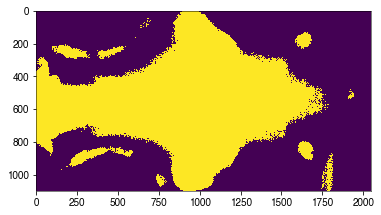

In [14]:
mask_ = mask[:, :, :, 0]
plt.imshow(mask_[3])

In [6]:
# rand_block = (14, 2, 5, 0)
# mask_ = mask.blocks[rand_block]
# M = Y_d.blocks[rand_block].squeeze().compute(scheduler='threads')
# M_dff = Y_dff.blocks[rand_block].squeeze().compute(scheduler='threads')
# M_pca = Y_svd.blocks[rand_block].squeeze().compute(scheduler='threads')
# Cn_ = local_correlations_fft(M)
# Cn = local_correlations_fft(M_pca)

# plt.imshow(Cn_, vmin=0, vmax=1)
# plt.title('Local correlation before denoise')
# plt.show()
# plt.imshow(Cn, vmin=0, vmax=1)
# plt.title('Local correlation after denoise')
# plt.show()

#### Compare location correlation at a larger region

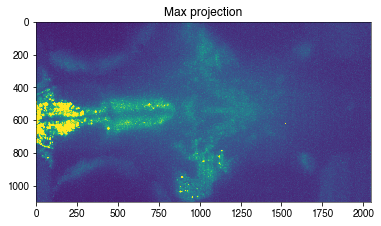

Number of processes to parallel: 72
Number of processes to parallel: 72


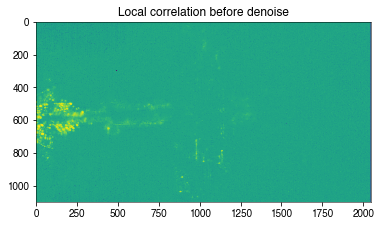

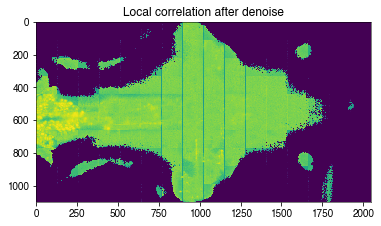

In [7]:
# M = Y_d.blocks[14, 5:7, 3:5].squeeze().compute(scheduler='threads')
# M_dff = Y_dff.blocks[14, 5:7, 3:5].squeeze().compute(scheduler='threads')
# M_pca = Y_svd.blocks[14, 5:7, 3:5].squeeze().compute(scheduler='threads')
M = Y_d.blocks[3, :, :].squeeze().compute()
M_dff = Y_dff.blocks[3, :, :].squeeze().compute()
M_pca = Y_svd.blocks[3, :, :].squeeze().compute()
plt.imshow(M.max(axis=-1), vmax=20)
plt.title('Max projection')
plt.show()
Cn_ = local_correlations_fft(M)
Cn = local_correlations_fft(M_pca)
plt.imshow(Cn_, vmin=0, vmax=1)
plt.title('Local correlation before denoise')
plt.show()
plt.imshow(Cn, vmin=0, vmax=1)
plt.title('Local correlation after denoise')
plt.show()

In [11]:
fdask.terminate_workers(cluster, client)

## Demix
This will generate the follow files at `save_root` folder
* `demix_rlt` for each block

### Check demix results

In [18]:
rand_block = (8, 1, 1, 0)
check_demix_cells(save_root, rand_block, plot_global=False, plot_mask=False)

0
No components


<Figure size 576x576 with 0 Axes>

18


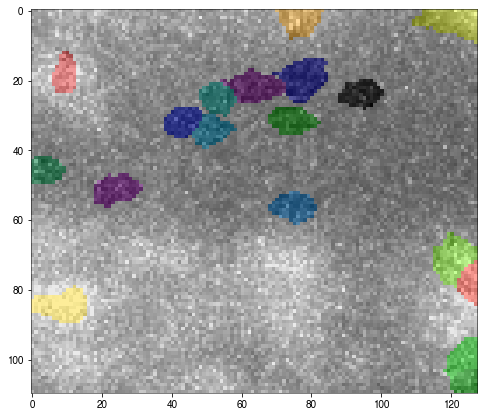

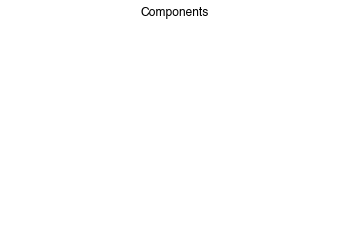

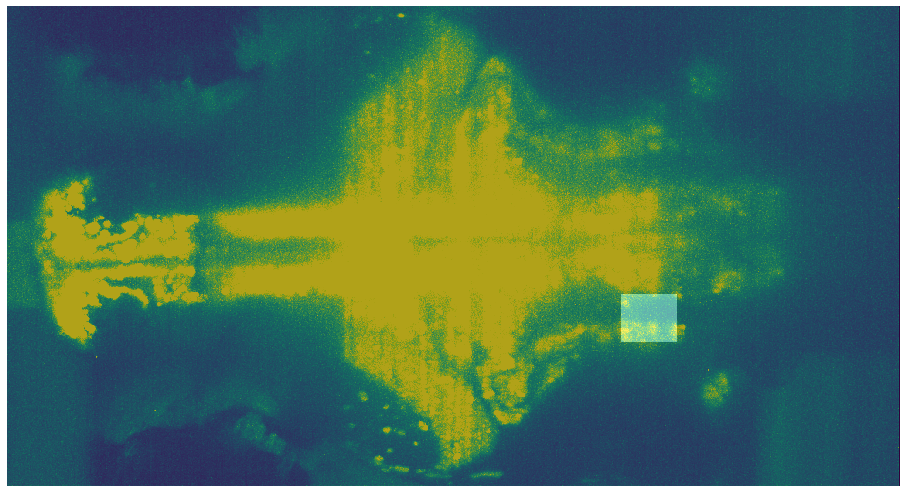

In [121]:
rand_block = (8, 6, 11, 0)
check_demix_cells(save_root, rand_block, plot_global=True, plot_mask=False)

In [92]:
M_mask = mask.blocks[8, 6, 11].squeeze().compute()

In [79]:
Y_t = da.from_zarr(f'{save_root}/motion_corrected_data.zarr')
Y_d_ = da.from_zarr(f'{save_root}/detrend_data.zarr')
Y_svd = da.from_zarr(f'{save_root}/masked_local_pca_data.zarr')

In [86]:
M = Y_d_.blocks[8, 6, 11].squeeze().compute()
M_svd = Y_svd.blocks[8, 6, 11].squeeze().compute()
M_svd = M_svd + M.mean(axis=-1, keepdims=True)

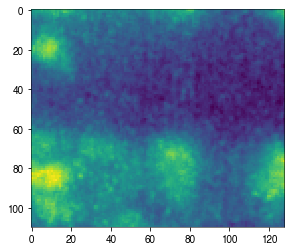

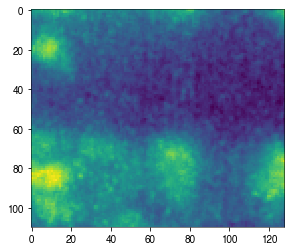

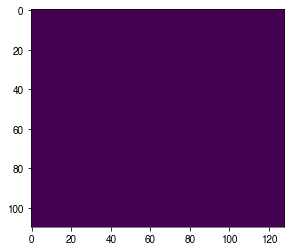

In [93]:
plt.imshow(M.mean(axis=-1))
plt.show()

plt.imshow(M_svd.mean(axis=-1))
plt.show()

plt.imshow(M_mask)
plt.show()

In [90]:
from utils import *

In [94]:
Y_svd_ = fb_pca_block(M, M_mask, block_id=None)

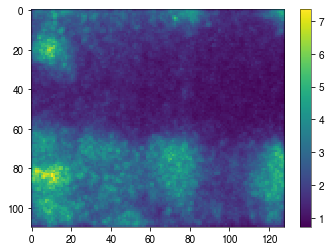

In [103]:
plt.imshow(Y_svd_.max(axis=-1).squeeze())
plt.colorbar()
plt.show()

In [96]:
Y_svd_.shape

(1, 110, 128, 10637)

In [109]:
cell_ = M[10:30, 0:20]
cell_s = Y_svd_[0, 10:30, 0:20]
# 

In [119]:
demix_blocks(Y_svd_, M_mask, save_folder=save_root, is_skip=False, block_id=(8, 6, 11, 0))

start 1 pass!
Get threshould data.....
find superpixels!
RAM used 6.1714 GB
RAM used 5.0743 GB
clear_variables: memory before: 6.171390533447266, after: 5.074306488037109, consumed: -1.0970840454101562; exec time: 00:00:00
Start with finding superpixels.....
Get components.....
time: 2.7953083515167236
start 2 pass!
fail at pass_num 4
start 1 pass!
Get threshould data.....
find superpixels!
RAM used 5.0743 GB
RAM used 5.0743 GB
clear_variables: memory before: 5.07427978515625, after: 5.07427978515625, consumed: 0.0; exec time: 00:00:00
Start with finding superpixels.....
Get components.....
time: 2.8834428787231445
rank 1 svd!
# of superpixels: 363
time: 5.791064500808716
find pure superpixels!
time: 0.007057666778564453
prepare iteration!
0.6528279781341553
time: 6.48072361946106
start 1 pass iteration!
start update_AC_l2_Y....
time: 0.8760502338409424
time: 0.885584831237793
time: 0.8862967491149902
time: 0.88582444190979
time: 0.88620924949646
time: 0.8866081237792969
time: 0.886735

array([[[[0.]]]])

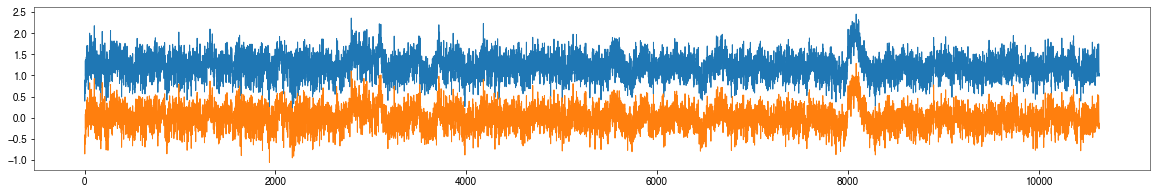

In [101]:
plt.figure(figsize=(20,3))
plt.plot(cell_.mean(axis=(0,1)))
plt.plot(cell_s.mean(axis=(0,1)))
plt.show()

In [16]:
# mask_ = mask.blocks[rand_block]
# M = Y_d.blocks[rand_block].squeeze().compute(scheduler='threads')
# M_dff = Y_dff.blocks[rand_block].squeeze().compute(scheduler='threads')
# M_pca = Y_svd.blocks[rand_block].squeeze().compute(scheduler='threads')
# Cn_ = local_correlations_fft(M)
# Cn = local_correlations_fft(M_pca)

# plt.imshow(Cn_, vmin=0.7, vmax=1)
# plt.title('Local correlation before denoise')
# plt.show()
# plt.imshow(Cn, vmin=0.95, vmax=1)
# plt.title('Local correlation after denoise')
# plt.show()

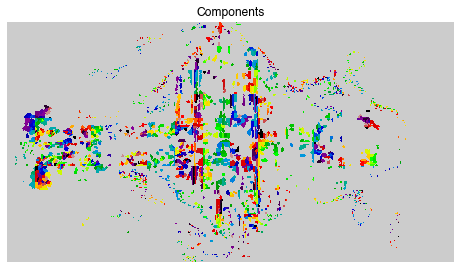

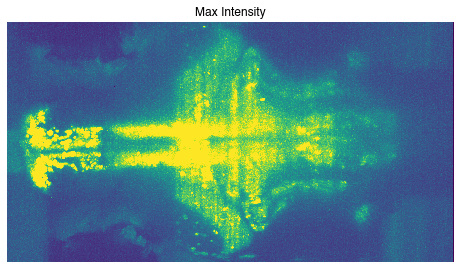

In [40]:
nlayer = 8
check_demix_cells_layer(save_root, nlayer, nsplit = nsplit)

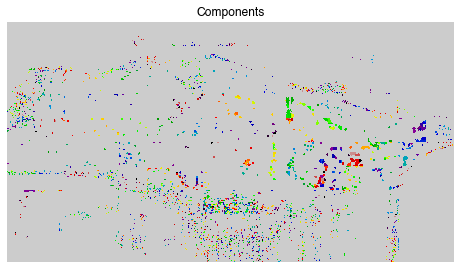

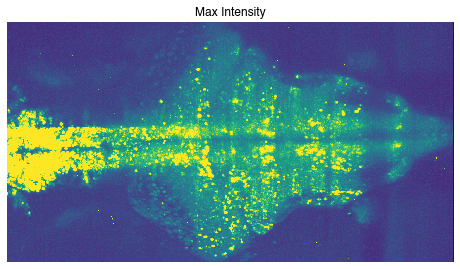

In [43]:
check_demix_cells_whole_brain(save_root, nsplit = (10, 16))